In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import rolling_split
import matplotlib.pyplot as plt
import seaborn
from data_processing import *

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("../Data/USDJPY_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro.drop(columns=['CPI YOY Index','JNCPIYOY Index'],inplace=True)
df_Macro["Dates"] = pd.to_datetime(df_Macro["Dates"])
df_Macro

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,USDJPYV1W Curncy,USDJPYV1M Curncy,USDJPYV1Y Curncy,USDJPYVON Curncy,JPYON Curncy,...,USGG10YR Index,USGG30YR Index,GJGB2 Index,GJGB10 Index,GJGB30 Index,SPX Index,VIX Index,NKY Index,Last_Return,Predict_Return
1,2000-01-04,101.70,103.30,101.46,103.22,12.500,12.400,14.0000,20.000,-1.595,...,6.4970,6.5370,0.325,1.738,2.459,1399.42,27.01,19002.86,0.017447,0.008913
2,2000-01-05,103.17,104.40,102.81,104.14,12.500,12.200,13.9000,20.000,-1.605,...,6.5940,6.6210,0.300,1.699,2.434,1402.11,26.41,18542.55,0.008913,0.010467
3,2000-01-06,104.15,105.58,103.98,105.23,13.500,13.050,14.4500,20.000,-1.672,...,6.5240,6.5530,0.305,1.685,2.408,1403.45,25.73,18168.27,0.010467,0.001045
4,2000-01-07,105.24,105.92,104.98,105.34,12.125,12.350,14.1500,10.000,-1.672,...,6.5150,6.5460,0.335,1.719,2.437,1441.47,21.72,18193.41,0.001045,-0.001709
5,2000-01-10,105.17,105.40,104.34,105.16,12.000,12.500,14.2500,10.000,-1.605,...,6.5520,6.5840,0.335,1.719,2.437,1457.60,21.71,18193.41,-0.001709,0.007512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,2024-07-15,157.84,158.42,157.19,158.06,9.265,9.470,9.0450,10.465,-2.451,...,4.2294,4.4571,0.336,1.065,2.192,5631.22,13.12,41190.68,0.001457,0.001835
6401,2024-07-16,158.06,158.86,158.00,158.35,7.645,9.020,9.1400,7.875,-2.355,...,4.1576,4.3721,0.319,1.029,2.170,5667.20,13.19,41275.08,0.001835,-0.013578
6402,2024-07-17,158.34,158.61,156.07,156.20,9.745,9.910,9.2325,12.285,-2.343,...,4.1576,4.3748,0.329,1.041,2.171,5588.27,14.48,41097.69,-0.013578,0.007490
6403,2024-07-18,156.20,157.40,155.38,157.37,9.355,9.585,9.1675,10.275,-2.341,...,4.2021,4.4217,0.342,1.042,2.162,5544.59,15.93,40126.35,0.007490,0.000699


In [3]:
df_tech = pd.read_csv("../Data/USDJPY_OHLC.csv")
df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])))
df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1980-01-03,238.35,238.35,238.35,238.35,-0.000419,-0.014894
2,1980-01-04,234.80,234.80,234.80,234.80,-0.014894,-0.013842
3,1980-01-07,231.55,231.55,231.55,231.55,-0.013842,0.013820
4,1980-01-08,234.75,234.75,234.75,234.75,0.013820,0.000852
5,1980-01-09,234.95,234.95,234.95,234.95,0.000852,0.003618
...,...,...,...,...,...,...,...
11618,2024-07-15,157.84,158.42,157.19,158.06,0.001457,0.001835
11619,2024-07-16,158.06,158.86,158.00,158.35,0.001835,-0.013578
11620,2024-07-17,158.34,158.61,156.07,156.20,-0.013578,0.007490
11621,2024-07-18,156.20,157.40,155.38,157.37,0.007490,0.000699


In [4]:
# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

USDJPY_close = df_tech['PX_LAST'].to_numpy()
USDJPY_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[5,100]],"RSI":[[5],[22],[100]],"MACD":[[26,12],[12,5],[42,18]],"ROC":[[5]],"Bollinger_Bands_lower":[[12],[100]],
             "Bollinger_Bands_upper":[[12],[100]],
              "CCI":[[5],[22],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)

df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_5_100,RSI_5,...,MACD_12_5,MACD_42_18,ROC_5,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_5,CCI_22,CCI_100
0,1980-05-21,224.40,224.40,224.40,224.40,-0.010364,-0.001560,228.470,-110004.700000,50.943396,...,-1.674802,-7.855266,-0.014925,223.781396,227.572993,234.276937,258.684007,-133.935685,-108.400235,-194.397015
1,1980-05-22,224.05,224.05,224.05,224.05,-0.001560,-0.012497,227.515,28289.229630,0.000000,...,-1.678434,-8.200525,-0.024172,222.764120,226.999937,234.002546,258.971063,-88.910469,-106.407634,-192.097577
2,1980-05-23,221.25,221.25,221.25,221.25,-0.012497,0.000000,226.460,126773.537037,0.000000,...,-2.607804,-8.459722,-0.033843,221.064940,226.367223,233.935060,259.332777,-114.900913,-127.214820,-214.528123
3,1980-05-26,221.25,221.25,221.25,221.25,0.000000,-0.009266,225.905,141133.632716,0.000000,...,-2.828137,-8.359897,-0.024256,220.323414,225.859303,232.618253,259.634697,-83.333030,-121.278686,-210.151438
4,1980-05-27,219.20,219.20,219.20,219.20,-0.009266,0.019617,225.050,10505.295062,0.000000,...,-2.722208,-8.593441,-0.023173,218.976009,225.135327,231.865658,260.047673,-107.440746,-135.228650,-223.374622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11518,2024-07-15,157.84,158.42,157.19,158.06,0.001457,0.001835,160.374,-32237.003333,13.258427,...,-0.883627,1.267316,-0.020269,157.793239,147.367981,163.220094,162.486819,-84.034283,-97.931610,65.014890
11519,2024-07-16,158.06,158.86,158.00,158.35,0.001835,-0.013578,160.065,167915.171481,11.872146,...,-0.918208,1.150419,-0.020657,157.348151,147.468675,163.243516,162.542925,-41.505073,-75.856633,74.680207
11520,2024-07-17,158.34,158.61,156.07,156.20,-0.013578,0.007490,159.516,61781.160988,14.130435,...,-1.637167,0.868412,-0.016620,156.243572,147.570365,163.471428,162.551435,-135.767526,-147.894131,42.722246
11521,2024-07-18,156.20,157.40,155.38,157.37,0.007490,0.000699,159.125,-12037.342840,20.761671,...,-1.599684,0.630174,-0.002915,155.799715,147.700627,163.236952,162.568973,-96.011227,-151.637400,36.481058


In [5]:
df_tech_part = df_tech.iloc[:,7:].copy()

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df_tech

,SMA_10,EMA_5_100,RSI_5,RSI_22,RSI_100,MACD_26_12,MACD_12_5,MACD_42_18,ROC_5,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_5,CCI_22,CCI_100,Dates
0,228.470,-110004.700000,50.943396,25.907473,36.399283,-6.612349,-1.674802,-7.855266,-0.014925,223.781396,227.572993,234.276937,258.684007,-133.935685,-108.400235,-194.397015,1980-05-21
1,227.515,28289.229630,0.000000,30.008244,37.439234,-6.413818,-1.678434,-8.200525,-0.024172,222.764120,226.999937,234.002546,258.971063,-88.910469,-106.407634,-192.097577,1980-05-22
2,226.460,126773.537037,0.000000,28.690169,37.590262,-6.319445,-2.607804,-8.459722,-0.033843,221.064940,226.367223,233.935060,259.332777,-114.900913,-127.214820,-214.528123,1980-05-23
3,225.905,141133.632716,0.000000,24.913234,36.298526,-6.608238,-2.828137,-8.359897,-0.024256,220.323414,225.859303,232.618253,259.634697,-83.333030,-121.278686,-210.151438,1980-05-26
4,225.050,10505.295062,0.000000,26.616153,36.504539,-7.353031,-2.722208,-8.593441,-0.023173,218.976009,225.135327,231.865658,260.047673,-107.440746,-135.228650,-223.374622,1980-05-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11518,160.374,-32237.003333,13.258427,36.116382,41.975146,0.567377,-0.883627,1.267316,-0.020269,157.793239,147.367981,163.220094,162.486819,-84.034283,-97.931610,65.014890,2024-07-15
11519,160.065,167915.171481,11.872146,35.913706,42.061609,0.458689,-0.918208,1.150419,-0.020657,157.348151,147.468675,163.243516,162.542925,-41.505073,-75.856633,74.680207,2024-07-16
11520,159.516,61781.160988,14.130435,32.134571,40.612960,0.187489,-1.637167,0.868412,-0.016620,156.243572,147.570365,163.471428,162.551435,-135.767526,-147.894131,42.722246,2024-07-17
11521,159.125,-12037.342840,20.761671,35.643564,41.402401,0.013562,-1.599684,0.630174,-0.002915,155.799715,147.700627,163.236952,162.568973,-96.011227,-151.637400,36.481058,2024-07-18


In [6]:
df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,USDJPYV1W Curncy,USDJPYV1M Curncy,USDJPYV1Y Curncy,USDJPYVON Curncy,JPYON Curncy,...,MACD_12_5,MACD_42_18,ROC_5,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_5,CCI_22,CCI_100
0,2000-01-04,101.70,103.30,101.46,103.22,12.500,12.400,14.0000,20.000,-1.595,...,0.042856,-0.778868,0.010970,101.380052,100.064451,103.254948,111.140749,101.575405,14.096914,-90.852598
1,2000-01-05,103.17,104.40,102.81,104.14,12.500,12.200,13.9000,20.000,-1.605,...,0.435289,-0.494427,0.016099,101.080509,100.124050,103.837824,110.927150,155.748379,192.087864,-55.564396
2,2000-01-06,104.15,105.58,103.98,105.23,13.500,13.050,14.4500,20.000,-1.672,...,0.829569,-0.229223,0.026534,100.676890,100.199955,104.756443,110.723845,121.071697,283.192119,-17.946413
3,2000-01-07,105.24,105.92,104.98,105.34,12.125,12.350,14.1500,10.000,-1.672,...,0.775111,-0.090027,0.038344,100.640054,100.272504,105.409946,110.532296,94.040862,255.235983,-0.310547
4,2000-01-10,105.17,105.40,104.34,105.16,12.000,12.500,14.2500,10.000,-1.605,...,0.962018,-0.119868,0.018795,100.689592,100.364381,105.863741,110.310219,45.467630,171.613789,-13.540168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,2024-07-15,157.84,158.42,157.19,158.06,9.265,9.470,9.0450,10.465,-2.451,...,-0.883627,1.267316,-0.020269,157.793239,147.367981,163.220094,162.486819,-84.034283,-97.931610,65.014890
6400,2024-07-16,158.06,158.86,158.00,158.35,7.645,9.020,9.1400,7.875,-2.355,...,-0.918208,1.150419,-0.020657,157.348151,147.468675,163.243516,162.542925,-41.505073,-75.856633,74.680207
6401,2024-07-17,158.34,158.61,156.07,156.20,9.745,9.910,9.2325,12.285,-2.343,...,-1.637167,0.868412,-0.016620,156.243572,147.570365,163.471428,162.551435,-135.767526,-147.894131,42.722246
6402,2024-07-18,156.20,157.40,155.38,157.37,9.355,9.585,9.1675,10.275,-2.341,...,-1.599684,0.630174,-0.002915,155.799715,147.700627,163.236952,162.568973,-96.011227,-151.637400,36.481058


In [7]:
df.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'USDJPYV1W Curncy',
       'USDJPYV1M Curncy', 'USDJPYV1Y Curncy', 'USDJPYVON Curncy',
       'JPYON Curncy', 'JPY1M Curncy', 'JPY12M Curncy', 'DXY Curncy',
       'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index', 'USGG2YR Index',
       'USGG10YR Index', 'USGG30YR Index', 'GJGB2 Index', 'GJGB10 Index',
       'GJGB30 Index', 'SPX Index', 'VIX Index', 'NKY Index', 'Last_Return',
       'Predict_Return', 'SMA_10', 'EMA_5_100', 'RSI_5', 'RSI_22', 'RSI_100',
       'MACD_26_12', 'MACD_12_5', 'MACD_42_18', 'ROC_5',
       'Bollinger_Bands_lower_12', 'Bollinger_Bands_lower_100',
       'Bollinger_Bands_upper_12', 'Bollinger_Bands_upper_100', 'CCI_5',
       'CCI_22', 'CCI_100'],
      dtype='object')

In [8]:
df["2Y spread"] = df["USGG2YR Index"]-df["GJGB2 Index"]
df["10Y spread"] = df["USGG10YR Index"]-df["GJGB10 Index"]
df["30Y spread"] = df['USGG30YR Index']-df['GJGB30 Index']

In [9]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

# set the threshold manually

0.001908


In [10]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

183
186
251


In [11]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':5,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.75}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()

def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()
    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
  return [loss_train, loss_test]   

def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")
    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
  return loss_ls   

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.807529146494125
test loss is 1.8038413759473388
-----------------------Epoch: 2----------------------------------
train loss is 1.6792186738580066
test loss is 1.651238113750262
-----------------------Epoch: 3----------------------------------
train loss is 1.5704288202679912
test loss is 1.5540772363069892
-----------------------Epoch: 4----------------------------------
train loss is 1.4679724996169816
test loss is 1.5162276167984137
-----------------------Epoch: 5----------------------------------
train loss is 1.398530539106308
test loss is 1.3921404306716922
-----------------------Epoch: 6----------------------------------
train loss is 1.3533481994388519
test loss is 1.3621386887906868
-----------------------Epoch: 7----------------------------------
train loss is 1.309896541304821
test loss is 1.2775703795222113
-----------------------Epoch: 8----------------------------------
train loss is 1.26925

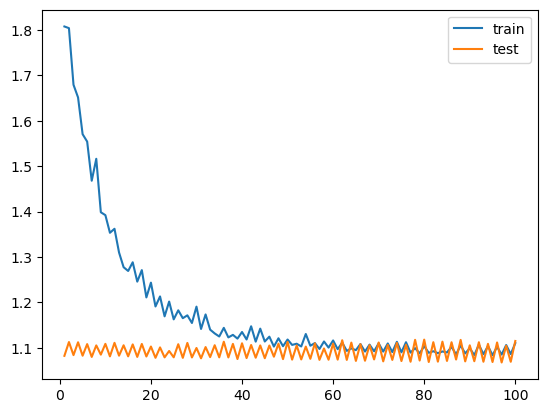

In [13]:
loss_array = np.array(loss_ls).reshape((2,epochs))
plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [14]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.36129032258064514

In [18]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.36)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.4778761061946903

In [19]:
act_predict_results.shape

torch.Size([113])

In [20]:
saved_path = "../trained_model/USDJPY_Mix_LSTM.pth"

torch.save(net_test.state_dict(),saved_path)